# Step 2 : **Color Transform & Gradient Threshold**

**Use color transforms, gradients, etc., to create a thresholded binary image.**

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

**Camera Calibration**

In [ ]:
# Read in the saved camera matrix and distortion coefficients
cameraCalibrationImgs = pickle.load( open( "Camera_Calibration.p", "rb" ) )
mtx = cameraCalibrationImgs["mtx"]
dist = cameraCalibrationImgs["dist"]

In [ ]:
! unzip test_images

In [ ]:
# Load test images using glob.
# read test images using cv2.imread .
testImages = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), 
                      glob.glob('test_images/*.jpg')))

imges readed in BGR 

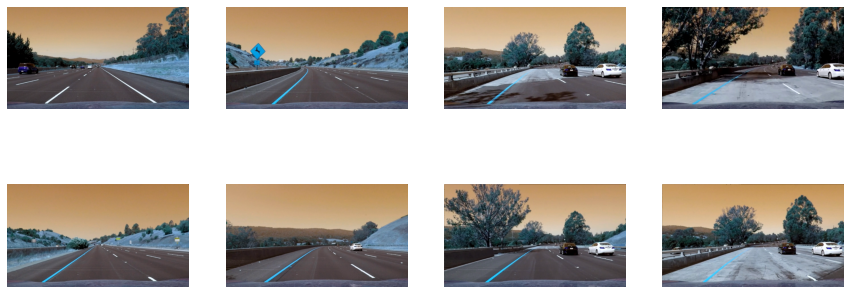

In [ ]:
def showImages(images, cols = 4, rows = 2, figsize=(15,6)):
    """
    Display `images`.
    """
    imgLength = len(images)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    indexes = range(cols * rows)
    for ax, index in zip(axes.flat, indexes):
        if index < imgLength:
            imagePathName, image = images[index]
            ax.imshow(image)
            ax.axis('off')

showImages(testImages)

**Undistort and color space**

I converted images to hls using cv2.COLOR_BGR2HLS because I readed imges using cv2.imread() this will read in an BGR image

In [ ]:
def cal_undistortAndHlS(img, mtx, dist) :

  """
  Undistort the image with `mtx`, `dist` and convert it to HLS.

  """
  #Undistorting a test image:
  undist = cv2.undistort(img, mtx, dist, None, mtx)

  # Convert to HLS color space
  undist_HLS = cv2.cvtColor(undist, cv2.COLOR_BGR2HLS)

  return undist_HLS

In [ ]:
# apply cal_undistortAndHlS function to testimages and pask the images in a list to show
UndistHLS_images = []
for fname in testImages:
    fileName, img = fname
    hlsimg = cal_undistortAndHlS(img, mtx, dist)
    UndistHLS_images.append(hlsimg)

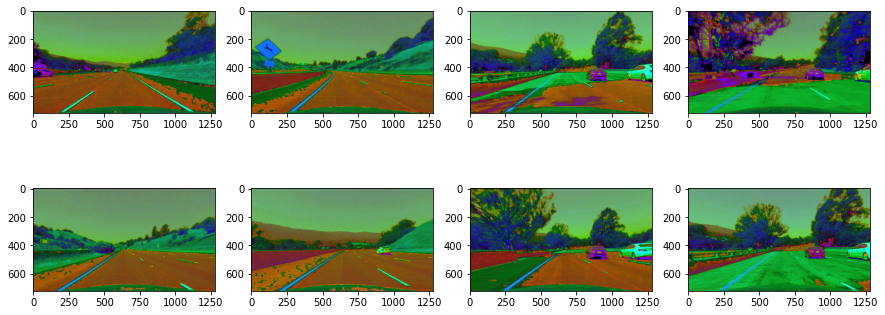

In [ ]:
def show_image(images):
    n: int = len(images)
    f = plt.figure(figsize=(15,6))
    for i in range(n):
        f.add_subplot(2,4, i + 1)
        plt.imshow(images[i])
    

show_image(UndistHLS_images)
# plt.savefig("UndistortHLS_Images.png")

**Sobel Operator**

The Sobel operator is at the heart of the Canny edge detection algorithm.Applying the Sobel operator to an image is a way of taking the derivative of the image in the x or y direction. 

In [ ]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):

    '''
    This function takes an image, gradient orientation, and threshold min / max values 
    returning a binary image [0, 255].

    ''' 
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


In [ ]:
# apply abs_sobel_thresh function to UndistHLS_images and pask the images in a list to show
grad_binaryx_imgs = []
grad_binaryy_imgs = []

for img in UndistHLS_images:
  grad_binaryx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
  grad_binaryx_imgs.append(grad_binaryx)
  grad_binaryy = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
  grad_binaryy_imgs.append(grad_binaryy)

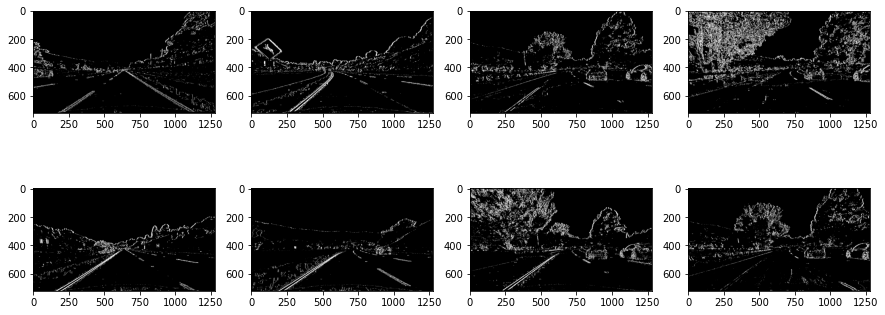

In [ ]:
#Thresholded with x-derivative
show_image(grad_binaryx_imgs)
# plt.savefig("Thresholded_x-derivative.png")

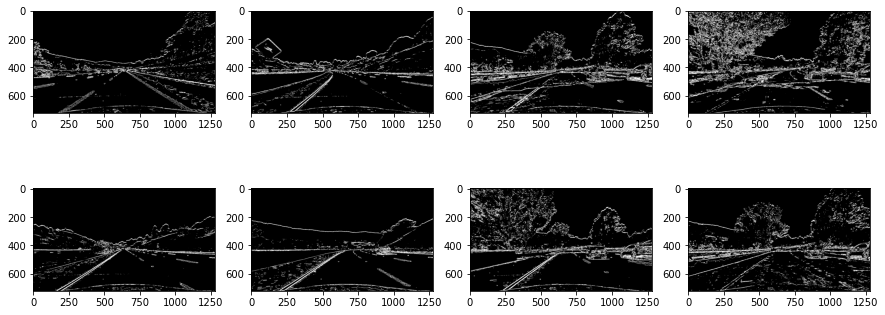

In [ ]:
#Thresholded with y-derivative
show_image(grad_binaryy_imgs)
# plt.savefig("Thresholded_y-derivative.png")

**Gradient magnitude**

(apply a threshold to the overall magnitude of the gradient, in both x and y.)

The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients. For a gradient in both the xx and yy directions, the magnitude is the square root of the sum of the squares.

abs_sobelx = sqrt{(sobel_x)^2}

abs_sobely = sqrt{(sobel_y)^2}

abs_sobelxy = sqrt{(sobel_x)^2+(sobel_y)^2} 

In [ ]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):

    '''
    This function  return the magnitude of the gradient for a given sobel kernel size and threshold values

    '''
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [ ]:
# apply mag_thresh function to UndistHLS_images and pask the images in a list to show
mag_binary_imgs = []

for img in UndistHLS_images:
  mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
  mag_binary_imgs.append(mag_binary)

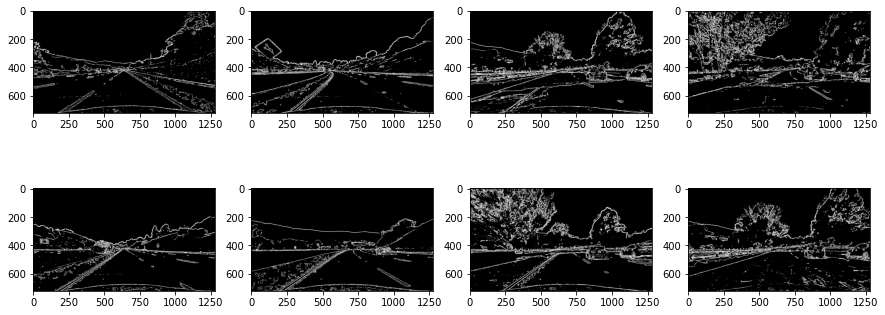

In [ ]:
show_image(mag_binary_imgs)
# plt.savefig("Thresholded_Magnitude.png")

**Direction of the Gradient**

In the case of lane lines, i'm interested only in edges of a particular orientation. So now i will explore the direction, or orientation, of the gradient.

The direction of the gradient is simply the inverse tangent (arctangent) of the yy gradient divided by the xx gradient:

arctan{(sobel_y/sobel_x)}arctan(sobel 
y
​
 /sobel 
x
​
 ).

Each pixel of the resulting image contains a value for the angle of the gradient away from horizontal in units of radians, covering a range of −π/2 to π/2. 

In [ ]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    '''
    This function is  to threshold an image for a given range and Sobel kernel

    '''
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [ ]:
# apply dir_threshold function to UndistHLS_images and pask the images in a list to show
dir_binary_imgs = []

for img in UndistHLS_images:
  dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
  dir_binary_imgs.append(dir_binary)

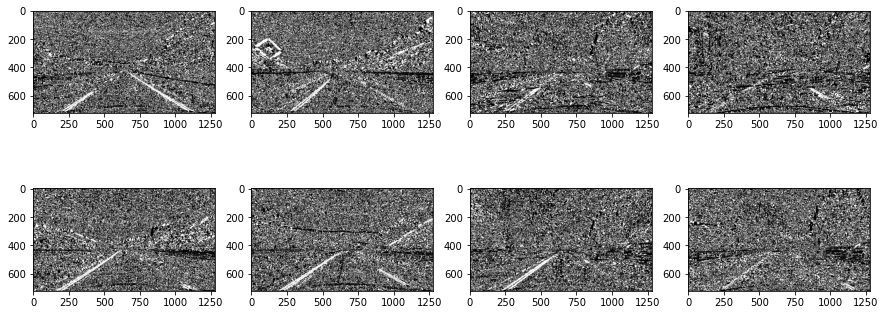

In [ ]:
show_image(dir_binary_imgs)
# plt.savefig("Thresholded_Grad_Dir.png")

**Combining Thresholds**

(use various aspects of your gradient measurements (x, y, magnitude, direction) to isolate lane-line pixels)

I'used thresholds of the x and y gradients, the overall gradient magnitude, and the gradient direction to focus on pixels that are likely to be part of the lane lines.

In [ ]:
#create a binary image result
imgLength = len(UndistHLS_images)
Combining_Thresholds_imgs = []
for index in range(0,imgLength) :
  Combining_Thresholds = np.zeros_like(dir_binary_imgs[index]) 
  Combining_Thresholds[((grad_binaryx_imgs[index] == 1) & (grad_binaryy_imgs[index] == 1)) | ((mag_binary_imgs[index] == 1) & (dir_binary_imgs[index] == 1))] = 1
  Combining_Thresholds_imgs.append(Combining_Thresholds)

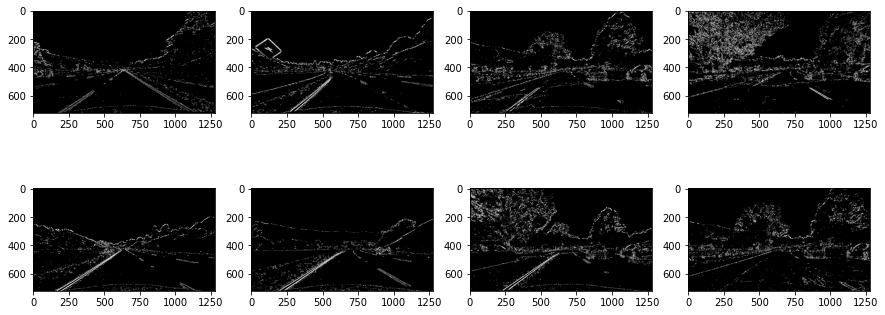

In [ ]:
show_image(Combining_Thresholds_imgs)
# plt.savefig("Combining_Thresholds.png")